In [349]:
import pandas as pd
import numpy as np
from IPython.display import display
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"

names = range(10)
dates = pd.date_range(start='2022-01-01', end='2022-12-31')

rng = np.random.default_rng()
activity = (rng.random((len(dates), len(names))) > 0.5).astype(int)
activity = (np.random.randn(len(dates), len(names)) > 0.5).astype(int)
activity = (np.random.normal(0.5, 0.5, (len(dates), len(names))) > 0.5).astype(int)
df = pd.DataFrame(activity, index=dates, columns=[f'user-{n}' for n in names])

sum_check = df.sum()
assert len(sum_check[sum_check == 0]) == 0

df.head()

,user-0,user-1,user-2,user-3,user-4,user-5,user-6,user-7,user-8,user-9
2022-01-01,1,0,0,1,0,0,1,0,0,1
2022-01-02,0,1,0,1,0,1,1,1,0,1
2022-01-03,1,1,1,0,0,0,1,0,0,0
2022-01-04,0,1,1,1,0,0,0,1,0,1
2022-01-05,1,0,0,0,1,1,0,1,1,1


# Quick Ratio

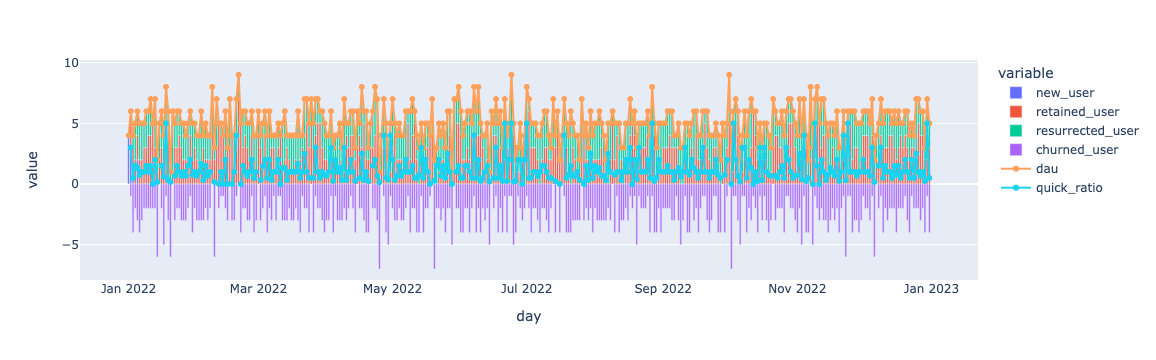

In [362]:
def get_dau(input_df):
    return df.sum(axis=1)

def common_new_user(df):
    original_df = df
    _, new_user_with_full_dates = original_df.align(
        pd.DataFrame(df.T.idxmax(axis=1)).assign(count=1).pivot(columns=0, values='count').T,
        join='outer'
    )
    return new_user_with_full_dates.fillna(0)

def get_new_user(df):
    return common_new_user(df).sum(axis=1)

def get_new_user_mask(df):
    return common_new_user(df).cumsum(axis=0).astype(bool)

def get_resurrected_user(df):
    shifted_df = (df - df.shift(1) == 1)
    not_new_user_df = ~common_new_user(df).astype(bool)
    left, right = shifted_df.align(not_new_user_df, axis=0, join='outer')
    return (left & right.fillna(True)).sum(axis=1).fillna(0)

def get_retained_user(df):
    return ((df - df.shift(1) == 0) & df.astype(bool)).sum(axis=1)

def get_churned_user(df):
    return (df - df.shift(1) == -1).sum(axis=1)

def get_continuous_churned_user(df):
    return ((df - df.shift(1) == 0) & ~df.astype(bool)).sum(axis=1)

new = df.assign(
    dau=get_dau(df),
    new_user=get_new_user(df),
    retained_user=get_retained_user(df),
    churned_user=get_churned_user(df),
    continuous_churned_user=get_continuous_churned_user(df),
    resurrected_user=get_resurrected_user(df),
)
new['dau_cal'] = new.new_user.fillna(0) + new.retained_user + new.resurrected_user
new['total'] = new.new_user.fillna(0) + new.retained_user + new.resurrected_user + new.churned_user + new.continuous_churned_user
new['check'] = new['dau'] == new['dau_cal']
new.index.name = 'day'

# display(new.head())
# # Check
# test1 = df.loc[['2022-01-01']].T
# display(test1[test1['2022-01-01'] == 1].sort_index())
# test2 = pd.DataFrame(df.T.idxmax(axis=1)).assign(count=1).pivot(columns=0, values='count').T.loc[['2022-01-01']].T.fillna(0)
# display(test2[test2['2022-01-01'] == 1].sort_index())


## Plot
new['quick_ratio'] = (new.new_user + new.resurrected_user) / new.churned_user
new['churned_user'] = -new['churned_user']
new['continuous_churned_user'] = -new['continuous_churned_user']

# fig_dau = go.Scatter(
#     x=new.index,
#     y=new['dau'],
#     text=new['dau'],
#     textposition='top center',
#     mode='lines+markers+text',
#     name='dau'
# )

# Non-WebGL mode
# fig_dau = new['dau'].plot(markers=True).data[0]
# fig_quick_ratio = new['quick_ratio'].plot(markers=True).data[0]

# WebGL mode
fig_dau = go.Scattergl(
    x=new.index,
    y=new['dau'],
    name='dau',
    mode='lines+markers',
)

fig_quick_ratio = go.Scattergl(
    x=new.index,
    y=new['quick_ratio'],
    name='quick_ratio',
    mode='lines+markers',
)

fig = new[['new_user', 'retained_user', 'resurrected_user', 'churned_user']].plot.bar()
fig.add_trace(fig_dau)
fig.add_trace(fig_quick_ratio)
fig

# Other metrics
* MAU / installation count
* new user / MAU
* DAU / MAU
* Dn / Mn / Wn metrics
* TBD
  * Lness
  * Cohort

In [360]:
def get_new_user_mau(df, freq='W-SUN'):
    return (
        pd.DataFrame(get_new_user(df)).reset_index().groupby(pd.Grouper(key='index', freq=freq)).sum()
        /
        pd.DataFrame(get_dau(df)).reset_index().groupby(pd.Grouper(key='index', freq=freq)).sum()
    )

get_new_user_mau(df).plot.bar()

def get_mau_installation(df, freq='W-SUN'):
    return (
        pd.DataFrame(get_dau(df)).reset_index().groupby(pd.Grouper(key='index', freq=freq)).sum().fillna(0)
        /
        pd.DataFrame(get_new_user(df)).reset_index().groupby(pd.Grouper(key='index', freq=freq)).sum().cumsum().fillna(0)
    )
    
get_mau_installation(df).plot()

def get_au1_au2(df, freq1, freq2):
    return (
        pd.DataFrame(get_dau(df)).reset_index().groupby(pd.Grouper(key='index', freq=freq1)).sum()
        /
        pd.DataFrame(get_dau(df)).reset_index().groupby(pd.Grouper(key='index', freq=freq2)).sum()
    ).dropna()

get_au1_au2(df, 'W', '4W').plot()

def get_dn_wn_mn_metrics(df, range_=[(1, 0), (7, 1), (28, 7), (84, 28), (84, 28), (364, 84)]):
    def app(x):
        first = x.idxmax()
        return (x.loc[first:].reset_index(drop=True))

    dn = df.T.apply(app, axis=1)    
    pairs = {f'd{pair[0]}_d{pair[1]}': ((dn.loc[:, pair[0]] == 1).sum() / (dn.loc[:, pair[1]] == 1).sum())
             for pair in range_ if dn.shape[1] > pair[0]}
    
    return pairs

get_dn_wn_mn_metrics(df, [(elem+1, elem) for elem in range(8)])

{'d1_d0': 0.7,
 'd2_d1': 0.5714285714285714,
 'd3_d2': 1.25,
 'd4_d3': 1.0,
 'd5_d4': 0.8,
 'd6_d5': 1.75,
 'd7_d6': 0.7142857142857143,
 'd8_d7': 1.6}